# 1. Threshold

In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np

iris = datasets.load_iris()
X = iris.data
y = iris.target

X.shape

(150, 4)

### Task 재구성

In [2]:
# noise 추가

random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]
X.shape

(150, 804)

In [3]:
# 0, 1 라벨에 속하는 붓꽃 샘플만 사용하도록 제한
X_train, X_test, y_train, y_test = train_test_split(X[y<2], y[y<2], 
                                                                        test_size=0.5, 
                                                                        random_state=random_state)
print(f"훈련, 테스트 셋에 사용된 라벨의 종류: {set(y_test)}")
print(f"훈련 데이터 shape: {X_train.shape}")
print(f"테스트 데이터 shape: {X_test.shape}")


훈련, 테스트 셋에 사용된 라벨의 종류: {0, 1}
훈련 데이터 shape: (50, 804)
테스트 데이터 shape: (50, 804)


### SVM 학습

In [5]:
from sklearn import svm

classifier = svm.SVC(kernel="poly", random_state=random_state)
classifier.fit(X_train, y_train)

classifier.score(X_test, y_test)

0.48

이진 분류인데도 불구하고 0.48의 굉장히 낮은 성능

In [6]:
classifier = svm.SVC(kernel="linear", random_state=random_state)
classifier.fit(X_train, y_train)

classifier.score(X_test, y_test)

0.8

kernel을 linear 로 변경하니 성능이 향상

In [7]:
classifier.predict(X_test)

array([0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1])

In [8]:
y_test

array([1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0])

In [9]:
# Logistic Regression 모델과 달리 SVM의 별도 범위 값을 값는 함수 decision_function (-1~1)
# 0보다 작으면 음성, 0보다 크면 양성이다.
y_score = classifier.decision_function(X_test)
print(y_score)

[-0.29512751  0.28798352  0.17635465  0.19056886  0.38391605 -0.30841065
 -0.10084254 -0.23481309  0.18576987 -0.36011033 -0.15726747 -0.25714889
 -0.14979669  0.02063898  0.04509171 -0.17239443  0.07287957 -0.0689103
 -0.13452462 -0.30697712  0.25404241 -0.28916471 -0.52061453  0.25252233
  0.02177777 -0.10980907  0.37468422  0.35303004 -0.6211302  -0.42920064
 -0.14770647  0.00593404 -0.34735296  0.32245409 -0.19439024  0.1288847
 -0.0320947  -0.23008604 -0.10135548 -0.46962186  0.05184235  0.0609688
  0.05632596  0.44769206 -0.38804349  0.24704844  0.16063684  0.0144203
 -0.03136574  0.11179177]


In [10]:
# confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

y_pred = classifier.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)
report_result = classification_report(y_test, y_pred)
print(report_result)


[[20  4]
 [ 6 20]]
              precision    recall  f1-score   support

           0       0.77      0.83      0.80        24
           1       0.83      0.77      0.80        26

    accuracy                           0.80        50
   macro avg       0.80      0.80      0.80        50
weighted avg       0.80      0.80      0.80        50



0보다 큰 값을 양성으로 분류했다. 이번에는 -0.1 보다 클 경우의 양성 분류를 테스트 해보겠다.

In [33]:
y_pred_new_threshold = classifier.decision_function(X_test) > -0.15
conf_mat = confusion_matrix(y_test, y_pred_new_threshold)
print(conf_mat)
report_result = classification_report(y_test, y_pred_new_threshold)
print(report_result)

[[15  9]
 [ 2 24]]
              precision    recall  f1-score   support

           0       0.88      0.62      0.73        24
           1       0.73      0.92      0.81        26

    accuracy                           0.78        50
   macro avg       0.80      0.77      0.77        50
weighted avg       0.80      0.78      0.77        50



# 2. Precision-Recall 커브

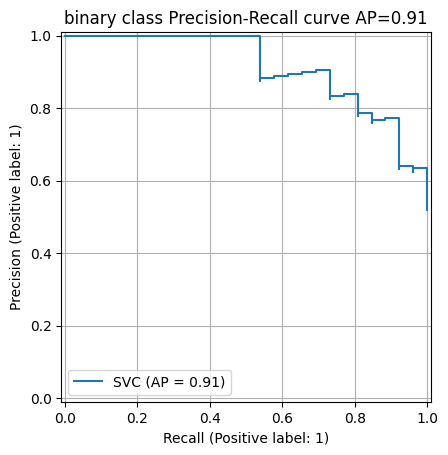

In [36]:
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt

display = PrecisionRecallDisplay.from_estimator(classifier, X_test, y_test)
display.ax_.set_title(f"binary class Precision-Recall curve AP={display.average_precision:0.2f}")
display.ax_.grid()

plt.show()

### PR AUC
$AP=\sum_{i=1}^{n}(R_{i}-R_{i-1})P_{i}$

In [37]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_pred)

print(f"평균 precision-recall score: {average_precision:0.2f}")

평균 precision-recall score: 0.76


In [40]:
# SVM의 poly 커널 average_precision_score

poly_classifier = svm.SVC(kernel="poly", random_state=random_state)
poly_classifier.fit(X_train, y_train)
y_pred = poly_classifier.predict(X_test)
poly_average_precision = average_precision_score(y_test, y_pred)
print(f"poly 평균 precision-recall score: {average_precision:0.2f}")

poly 평균 precision-recall score: 0.76


Text(0.5, 1.0, 'binary class precision-recall curve: AP=0.52')

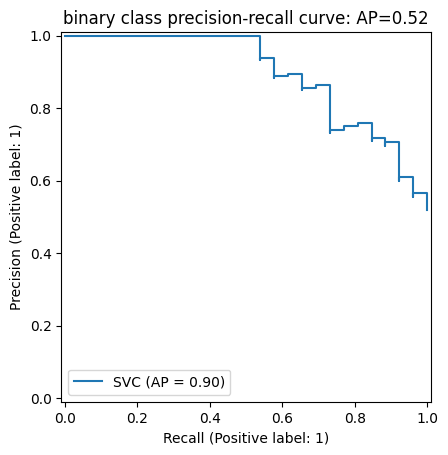

In [41]:
display = PrecisionRecallDisplay.from_estimator(poly_classifier, X_test, y_test)
display.ax_.set_title(f"binary class precision-recall curve: AP={poly_average_precision}")

# 3. ROC 커브
* ROC(Receiver Operating Characteristic Curve)
* ROC는 Confusion Matrix 수치를 활용해, 분류 성능을 그래프로 표현하는 방법이다.
---
### ROC 곡선
* ROC를 그리는 축인 TP Rate와 FP Rate는 Precision, Recall 과 비슷해보이지만 조금 다른 개념이다.
* TP Rate와 FP Rate 계산 방법
  - $TPR(Sensitivity)=\frac{TP}{TP+FN}$
  - $FPR(1-Sensifivity)=\frac{FP}{TN+FP}$
* TP Rate(TPR) 수식은 Recall이다.
* FP Rate는 음성 샘플에 대한 Recall이다.

In [45]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

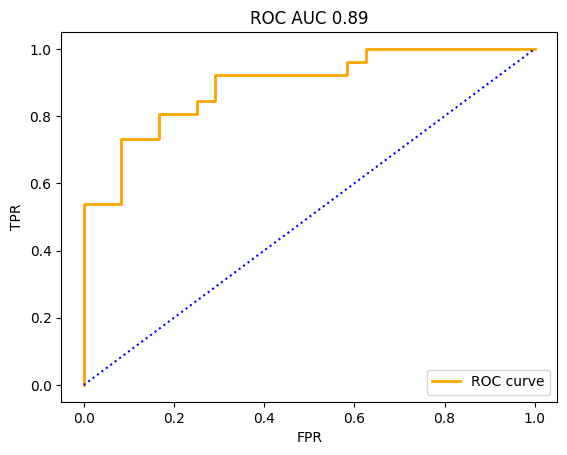

In [67]:
plt.figure()
plt.plot(fpr, tpr, label="ROC curve", color="orange", lw=2)
plt.plot([0, 1], [0, 1], color="blue", linestyle="dotted")
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.title(f"ROC AUC {round(roc_auc, 2)}")
plt.legend(loc="lower right")